In [2]:
import pandas as pd
from cProfile import label
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

def exp1_plot_throughput(csv_file, ylim, optimal):
    df = pd.read_csv(csv_file)
    df.rename(columns=str.strip, inplace=True)

    plt.figure(figsize=(6, 4))
    plt.xlabel('Episode')
    plt.ylabel('Effective Throughput (tps)')
    plt.ylim(0, ylim)
    plt.plot(range(1, len(df) + 1), df['throughput'], label='Learned')
    plt.grid(True)
    plt.axhline(y=optimal, color="red", linestyle="--", label="Optimal")
    plt.legend(frameon=False)

#### 1. Workload 1
Workload 1: low contention, high transaction arrival rate, high execution delay. 

The initial architecture for learned system is (blocksize=50, XO).

The best archiectures is (blocksize=20~50, XO).

**(1) Use the unallocated disk partitions or additional disk drives (Node-local dataset in CloudLab)**
```
Filesystem                                 Size  Used Avail Use% Mounted on
/dev/mapper/emulab-bs--0                    28G  234M   26G   1% /mydata
```

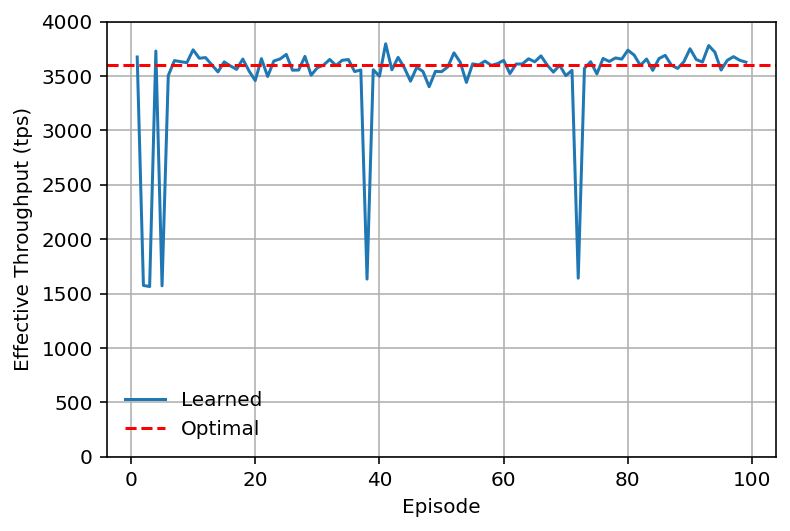

In [2]:
exp1_plot_throughput('ts_episode_100_2.csv', 4000, 3600)

**(2) Use the primary disk partition (system partition on the boot disk)**
```
Filesystem                                 Size  Used Avail Use% Mounted on
/dev/sda1                                   16G   12G  3.1G  80% /
```

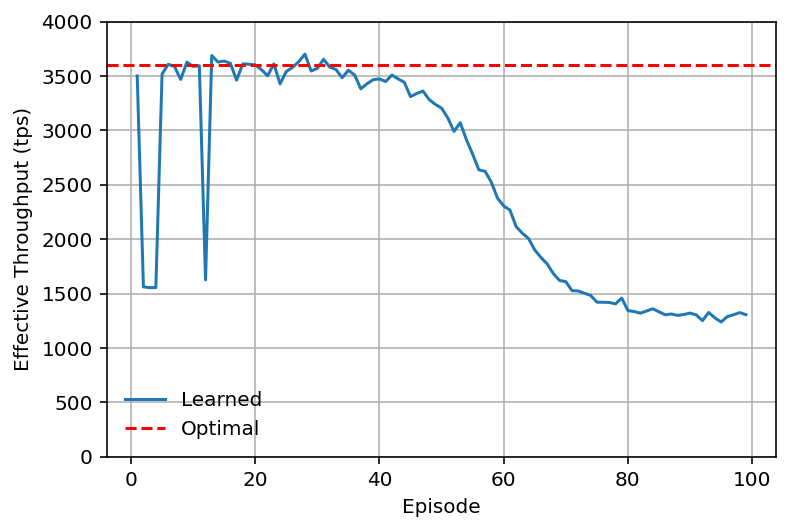

In [3]:
exp1_plot_throughput('ts_episode_100_1.csv', 4000, 3600)

#### 2. Workload 2
Workload 2: high contention, relatively high write ratio, high transaction arrival rate, low execution delay. 

The initial architecture for learned system is (blocksize=50, XO).

The best archiectures is (blocksize=50, OX), and (blocksize=160, OXII).

<!-- <font color="red"> 
Problem in Thompson sampling: 

Thompson sampling does not "explore" the architecture space enough. It seems we need to seed the random forest (the predictor) with some experience obtained from grid search. Otherwise, if we use bootstrap on training data to emulate sampling from the model parameter $\theta$, we have a cold start problem.




</font> -->

**(1) Deterministic tie breaking**

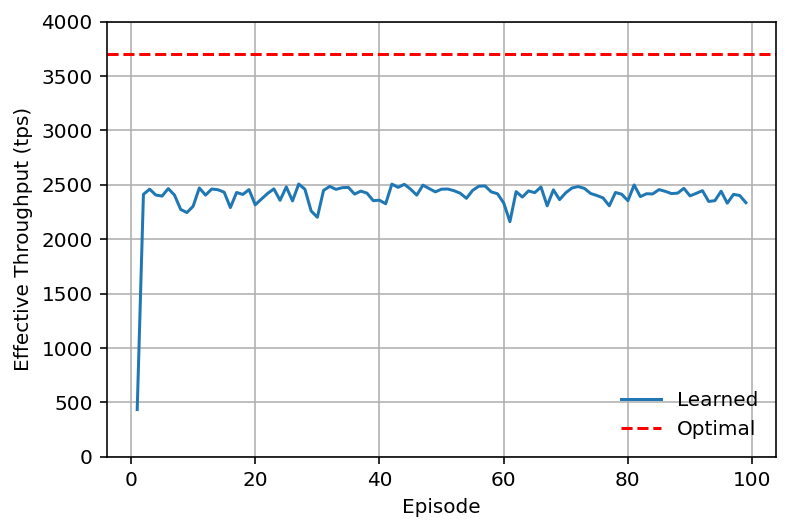

In [4]:
exp1_plot_throughput('ts_episode_100_3.csv', 4000, 3700)

**(2) Random tie breaking, prior = uniform distribution**

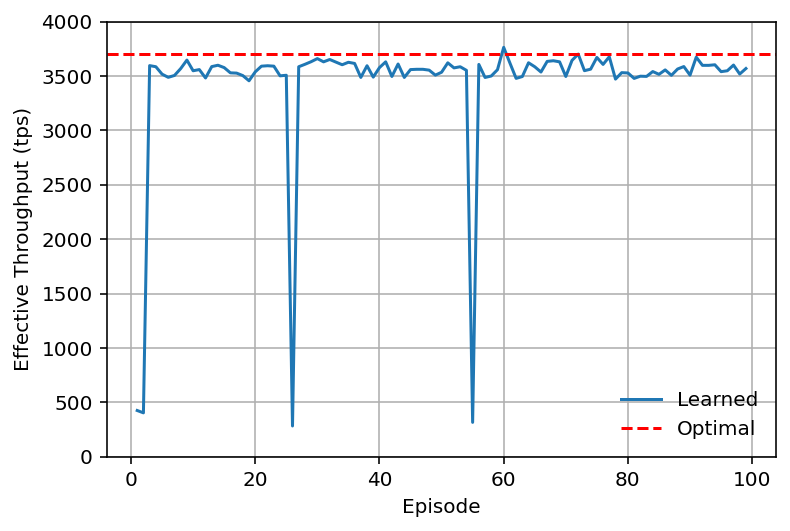

In [5]:
exp1_plot_throughput('ts_episode_100_5.csv', 4000, 3700)

#### 3. Workload 3
Workload 3: high contention, relatively high read ratio, high transaction arrival rate, high execution delay (~5000us). 

The initial architecture for learned system is (blocksize=50, XO).

The best archiectures is (blocksize=10~20, XO, reorder).

<!-- <font color="red"> 
To be fixed: in the learning framework, I am not able to reproduce some results recorded in the google doc.

* (blocksize=25, XO): 1916 -> 584 tps
* (blocksize=25, XO, reorder): 2208 -> 566 tps

</font> -->


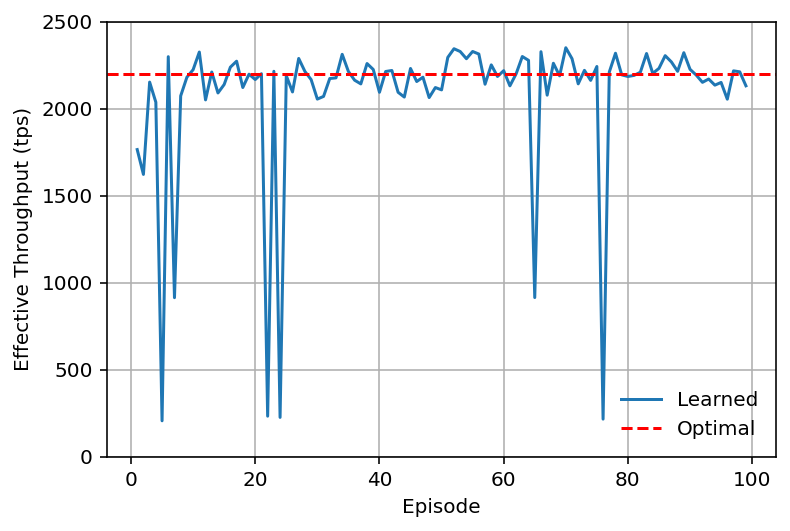

In [4]:
exp1_plot_throughput('ts_episode_100_11.csv', 2500, 2200)

The result above is measured when 1) we haven't implemented OXII yet; 2) we rule out some very bad actions (e.g., blocksize=200, XO, reorder) since we haven't implemented the slow path yet.

The result below is measure now when we implemented the full system.

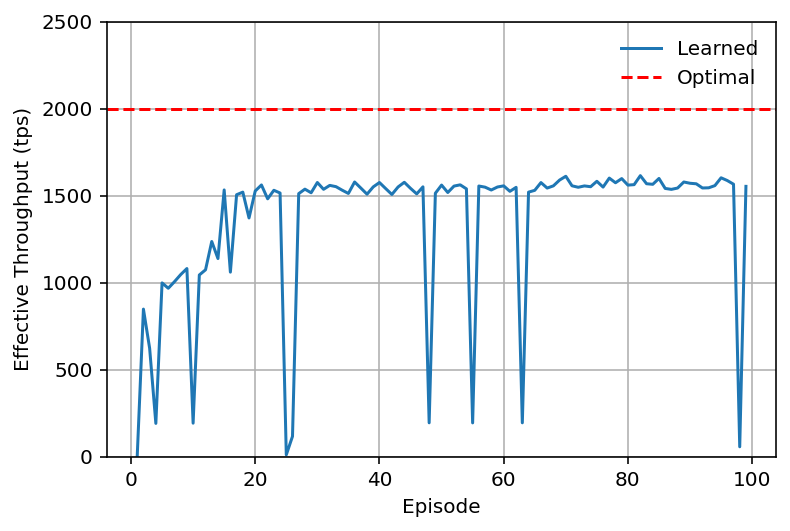

In [3]:
exp1_plot_throughput('ts_episode_100_12.csv', 2500, 2000)

#### 4. Workload 4
Workload 4: high contention, relatively high read ratio, low transaction arrival rate, high execution delay.

The initial architecture for learned system is (blocksize=50, XO).

The best architecture is (blocksize=1, XO).

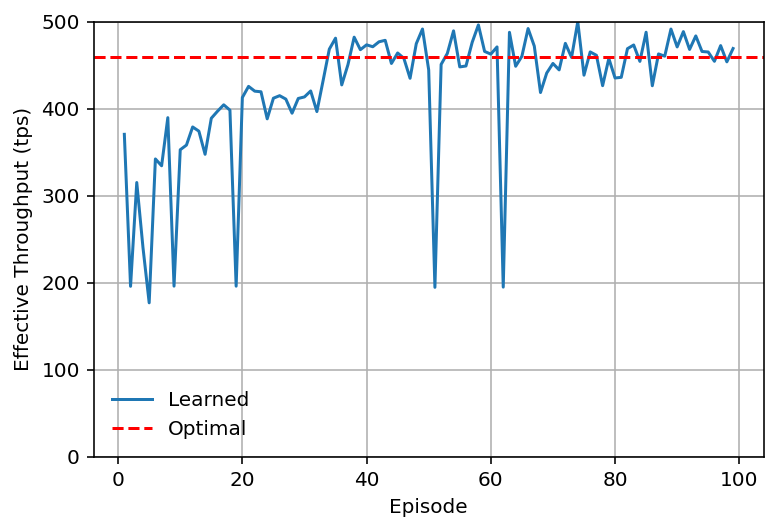

In [6]:
exp1_plot_throughput('ts_episode_100_6.csv', 500, 460)

#### 5. Switching workloads

(1) Case 1. We use the experiences gained from workload 4 (100 episodes) to seed the learning system, and then run workload 2.
<!-- 
<font color="red"> 
It is converging to optimal, but the convergence speed is much slower than the figures above, i.e., when we only run workload 2. Need to investigate the reason.

</font> -->

**No experiences window**

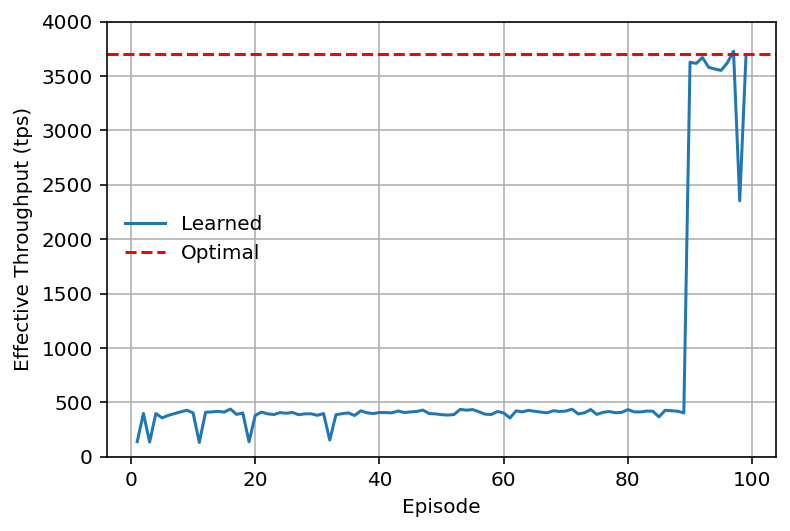

In [7]:
exp1_plot_throughput('ts_episode_100_7.csv', 4000, 3700)

We run it again, and also plot the predicted performance of the optimal architecture. This time, the learning system does not converge.

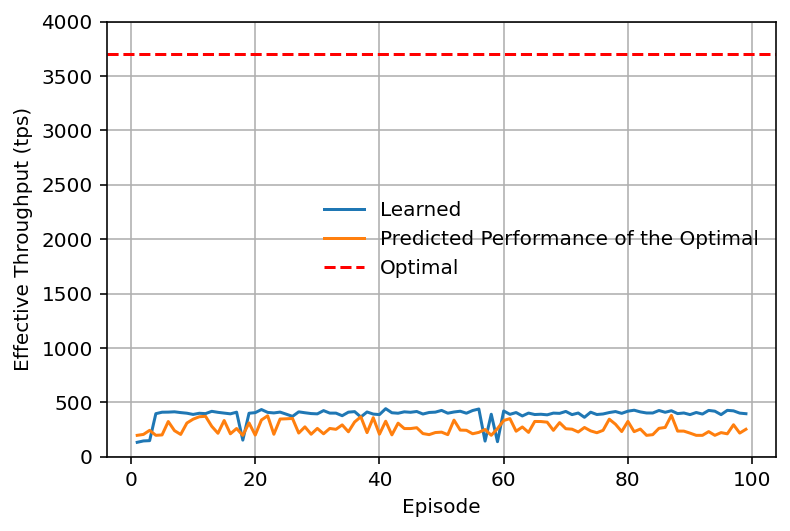

In [8]:
df = pd.read_csv('ts_episode_100_8.csv')
df.rename(columns=str.strip, inplace=True)

plt.figure(figsize=(6, 4))
plt.xlabel('Episode')
plt.ylabel('Effective Throughput (tps)')
plt.ylim(0, 4000)
plt.plot(range(1, len(df) + 1), df['throughput'], label='Learned')
plt.plot(range(1, len(df) + 1), df['optimal_action_predicted'], label='Predicted Performance of the Optimal')
plt.grid(True)
plt.axhline(y=3700, color="red", linestyle="--", label="Optimal")
plt.legend(frameon=False)


**Experiences window = 40**

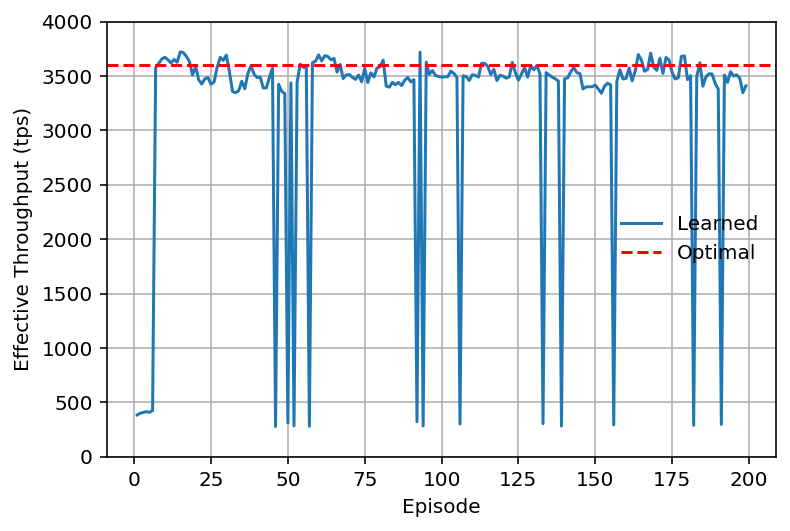

In [44]:
exp1_plot_throughput('ts_episode_200_1.csv', 4000, 3600)


**Experiences window = 100**

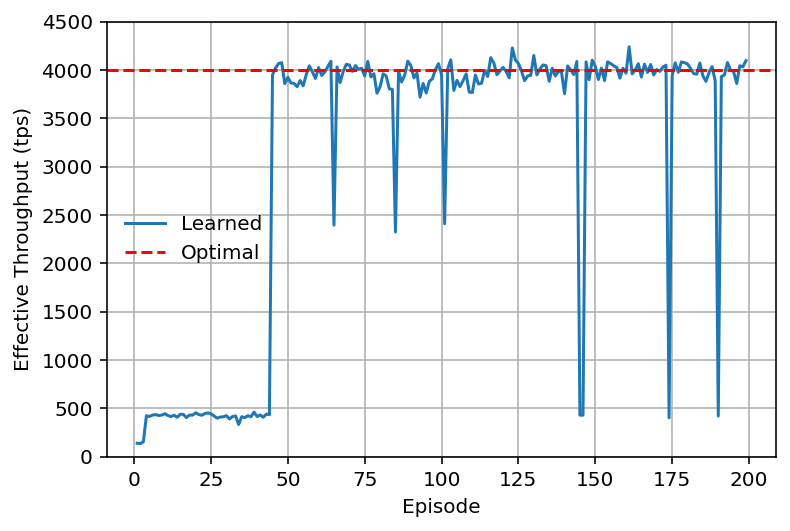

In [48]:
exp1_plot_throughput('ts_episode_200_4.csv', 4500, 4000)

(2) Case 2/3/4. If we switch from workload 2 to workload 4, and run workload 4, it converges as fast as no switching happened.

**No experiences window**

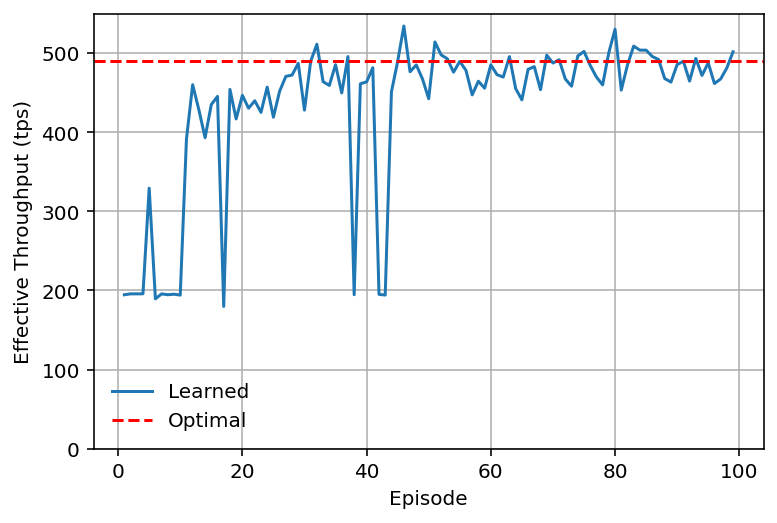

In [11]:
exp1_plot_throughput('ts_episode_100_9.csv', 550, 490)


**Experiences window = 40**

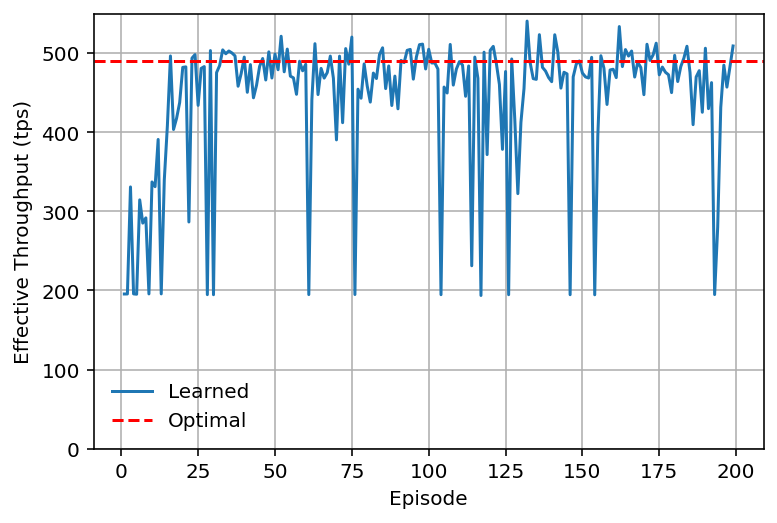

In [45]:
exp1_plot_throughput('ts_episode_200_2.csv', 550, 490)

**Experiences window = 100**

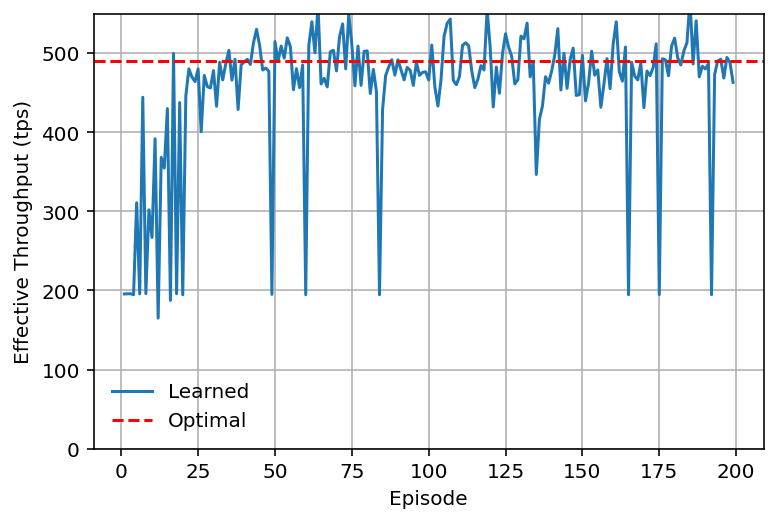

In [46]:
exp1_plot_throughput('ts_episode_200_3.csv', 550, 490)


#### 6. Episode duration
One of the worst case scenario is below. The system get stucked at Johnson's algorithm for more than 4 minutes.

Workload:
```json
{
    "write_ratio": 0.9,
    "hot_key_ratio": 0.95,
    "num_keys": 10000,
    "num_hot_keys": 10,
    "trans_per_interval": 300,
    "interval": 50000,
    "execution_delay": 0
}
```
Architecture chosen:
```json
{
    "blocksize": 100,
    "early_execution": true,
    "reorder": true
}
```

#### 7. Mode collapse?

In [2]:
import pandas as pd
# df1 = pd.read_csv('ts_episode_100_6.csv')
# df1.rename(columns=str.strip, inplace=True)
# df2 = pd.read_csv('ts_episode_100_7.csv')
# df2.rename(columns=str.strip, inplace=True)

df = pd.read_csv('ts_episode_100_14.csv')
df.rename(columns=str.strip, inplace=True)

In [3]:
df.head(10)

,write_ratio,hot_key_ratio,trans_arrival_rate,execution_delay (us),blocksize,early_execution,reorder,throughput,feature_extraction_overhead (s),training_overhead (s),inference_overhead (s),communication_overhead (s),episode_duration (s)
0,0.194533,0.055748,2996.255879,5080.229467,50.0,1.0,0.0,1463.044347,0.100395,0.000000,0.000000,0.206344,3.027674
1,0.207067,0.055158,2993.493343,5080.605467,700.0,0.0,1.0,873.688156,0.097562,0.154061,0.014199,0.206611,8.411861
2,0.201344,0.055769,3019.719507,5096.803804,350.0,1.0,0.0,659.100462,0.091251,0.154652,0.014848,0.176454,5.036473
3,0.188163,0.055063,3105.902398,5081.490340,190.0,0.0,0.0,194.039824,0.102648,0.153382,0.013946,0.178834,15.346817
4,0.190256,0.056856,2934.001657,5107.918208,90.0,0.0,1.0,1541.477507,0.038480,0.150193,0.014025,0.194719,4.952476
5,0.200669,0.054348,3139.845437,5094.696921,120.0,0.0,1.0,1615.635179,0.092399,0.152904,0.014137,0.143954,5.778409
6,0.203629,0.056777,3114.457572,5095.227957,140.0,0.0,0.0,194.266239,0.096020,0.151942,0.014056,0.186802,16.123637
7,0.188214,0.056837,2934.020173,5107.305714,90.0,1.0,1.0,1142.343638,0.073592,0.164509,0.013890,0.086566,2.791917
8,0.194510,0.054950,3095.863724,5083.834510,110.0,0.0,1.0,1542.113955,0.095531,0.155649,0.013726,0.095981,4.959374
9,0.205756,0.054811,3131.346794,5098.876841,130.0,0.0,1.0,1509.779951,0.099336,0.154492,0.014021,0.114258,6.061014


In [17]:
# df1 = df1[(df1['early_execution'] != 0) | (df1['blocksize'] == 10)]
# df_X_train = pd.concat([df1.loc[:, 'write_ratio':'reorder'], df2.loc[:10, 'write_ratio':'reorder']])
# df_y_train = pd.concat([df1.loc[:, 'throughput'], df2.loc[:10, 'throughput']])

df_X_train = df.loc[:50, 'write_ratio':'reorder']
df_y_train = df.loc[:50, 'throughput']

In [18]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
rf = RandomForestRegressor()
rf.fit(df_X_train.values, df_y_train.values)

RandomForestRegressor()

In [19]:
blocksizes = [1] + list(range(10, 200, 10)) + list(range(200, 1000, 50))
early_execution = [False, True]
reorder = [False, True]
actions = []
for dim_1 in blocksizes:
    for dim_2 in early_execution:
        for dim_3 in reorder:
            actions.append(np.array([dim_1, dim_2, dim_3]))
actions_matrix = np.vstack(actions)
enumeration_matrix = np.hstack((np.zeros((actions_matrix.shape[0], 4)), actions_matrix))

In [20]:
state = df.iloc[51, [0, 1, 2, 3]].values
enumeration_matrix[:, 0:4] = state
enumeration_matrix

array([[2.03342246e-01, 5.49987627e-02, 3.07928416e+03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.03342246e-01, 5.49987627e-02, 3.07928416e+03, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.03342246e-01, 5.49987627e-02, 3.07928416e+03, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [2.03342246e-01, 5.49987627e-02, 3.07928416e+03, ...,
        9.50000000e+02, 0.00000000e+00, 1.00000000e+00],
       [2.03342246e-01, 5.49987627e-02, 3.07928416e+03, ...,
        9.50000000e+02, 1.00000000e+00, 0.00000000e+00],
       [2.03342246e-01, 5.49987627e-02, 3.07928416e+03, ...,
        9.50000000e+02, 1.00000000e+00, 1.00000000e+00]])

In [21]:
prediction = rf.predict(enumeration_matrix)

In [22]:
df_results = pd.concat([pd.DataFrame(enumeration_matrix), pd.DataFrame(prediction)], axis = 1)
pd.set_option('display.max_rows', None)
df_results

,0,1,2,3,4,5,6,0
0,0.203342,0.054999,3079.284157,5097.10615,1.0,0.0,0.0,917.990465
1,0.203342,0.054999,3079.284157,5097.10615,1.0,0.0,1.0,1542.370619
2,0.203342,0.054999,3079.284157,5097.10615,1.0,1.0,0.0,750.742844
3,0.203342,0.054999,3079.284157,5097.10615,1.0,1.0,1.0,800.479520
4,0.203342,0.054999,3079.284157,5097.10615,10.0,0.0,0.0,917.990465
5,0.203342,0.054999,3079.284157,5097.10615,10.0,0.0,1.0,1542.370619
6,0.203342,0.054999,3079.284157,5097.10615,10.0,1.0,0.0,750.742844
7,0.203342,0.054999,3079.284157,5097.10615,10.0,1.0,1.0,800.479520
8,0.203342,0.054999,3079.284157,5097.10615,20.0,0.0,0.0,917.990465
9,0.203342,0.054999,3079.284157,5097.10615,20.0,0.0,1.0,1542.370619


In [23]:
df_results.describe()

,0,1,2,3,4,5,6,0
count,144.000000,1.440000e+02,144.000000,144.00000,144.000000,144.000000,144.000000,144.000000
mean,0.203342,5.499876e-02,3079.284157,5097.10615,308.361111,0.500000,0.500000,728.325969
std,0.000000,6.963114e-18,0.000000,0.00000,287.933768,0.501745,0.501745,342.948419
min,0.203342,5.499876e-02,3079.284157,5097.10615,1.000000,0.000000,0.000000,338.751304
25%,0.203342,5.499876e-02,3079.284157,5097.10615,87.500000,0.000000,0.000000,439.416247
50%,0.203342,5.499876e-02,3079.284157,5097.10615,175.000000,0.500000,0.500000,687.303862
75%,0.203342,5.499876e-02,3079.284157,5097.10615,512.500000,1.000000,1.000000,909.573901
max,0.203342,5.499876e-02,3079.284157,5097.10615,950.000000,1.000000,1.000000,1551.510152


In [46]:
best_index = np.argmax(prediction)
best_index

0

In [77]:
np.random.choice(np.flatnonzero(np.isclose(prediction, prediction.max())), replace=True)

70